In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

LATENT_DIM = 100
W_DIM = 128
BATCH_SIZE = 64
IMG_SHAPE = (28, 28, 1)
EPOCHS = 2000
N_CRITIC = 5
LAMBDA_GP = 10
EPS = 1e-8

In [2]:
def build_mapping_network(latent_dim=LATENT_DIM, w_dim=W_DIM):
    z = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation='relu')(z)
    x = layers.Dense(256, activation='relu')(x)
    w = layers.Dense(w_dim)(x)
    return Model(z, w, name="MappingNetwork")

In [3]:
class LearnedConstant(layers.Layer):
    def __init__(self, channels=256, res=4):
        super().__init__()
        self.channels = channels
        self.res = res
    def build(self, _):
        self.const = self.add_weight(shape=(1, self.res, self.res, self.channels),
                                     initializer="random_normal", trainable=True)
    def call(self, batch_like):
        b = tf.shape(batch_like)[0]
        return tf.tile(self.const, [b, 1, 1, 1])

class NoiseInjection(layers.Layer):
    def build(self, input_shape):
        self.weight = self.add_weight(shape=(1,), initializer="zeros", trainable=True)
    def call(self, x):
        noise = tf.random.normal(tf.shape(x))
        return x + self.weight * noise

class AdaIN(layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.dense_s = layers.Dense(channels)
        self.dense_b = layers.Dense(channels)
    def call(self, x, w):
        mean, var = tf.nn.moments(x, [1,2], keepdims=True)
        std = tf.sqrt(var + EPS)
        x_norm = (x - mean) / std
        s = tf.reshape(self.dense_s(w), [-1,1,1,x.shape[-1]])
        b = tf.reshape(self.dense_b(w), [-1,1,1,x.shape[-1]])
        return x_norm * (s + 1) + b
    

In [4]:
def styled_conv_block(x, w, filters):
    x = NoiseInjection()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = AdaIN(filters)(x, w)
    x = layers.LeakyReLU(0.2)(x)
    return x

def build_stylegan_generator(latent_dim=LATENT_DIM, w_dim=W_DIM, out_res=28):
    z = layers.Input(shape=(latent_dim,))
    mapping = build_mapping_network(latent_dim, w_dim)
    w = mapping(z)

    const = LearnedConstant(256, 4)
    x = const(z)
    x = styled_conv_block(x, w, 256)
    x = layers.UpSampling2D()(x)
    x = styled_conv_block(x, w, 128)
    x = layers.UpSampling2D()(x)
    x = styled_conv_block(x, w, 64)
    x = layers.UpSampling2D()(x)
    x = styled_conv_block(x, w, 32)

    out = layers.Conv2D(1, 1, activation='tanh', padding='same')(x)
    out = layers.Resizing(out_res, out_res)(out)
    return Model(z, out, name="StyleGAN_Generator")

generator = build_stylegan_generator()
generator.summary()

Model: "StyleGAN_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ learned_constant    │ (None, 4, 4, 256) │      4,096 │ input_layer[0][0] │
│ (LearnedConstant)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_injection     │ (None, 4, 4, 256) │          1 │ learned_constant… │
│ (NoiseInjection)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 4, 4, 256) │    590,080 │ noise_injection[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MappingNetwork      │ (None, 128)       │    124,544 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ada_in (AdaIN)      │ (None, 4, 4, 256) │     66,048 │ conv2d[0][0],     │
│                     │                   │            │ MappingNetwork[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 4, 4, 256) │          0 │ ada_in[0][0]      │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8, 256) │          0 │ leaky_re_lu[0][0] │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_injection_1   │ (None, 8, 8, 256) │          1 │ up_sampling2d[0]… │
│ (NoiseInjection)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    295,040 │ noise_injection_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ada_in_1 (AdaIN)    │ (None, 8, 8, 128) │     33,024 │ conv2d_1[0][0],   │
│                     │                   │            │ MappingNetwork[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 128) │          0 │ ada_in_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 16, 16,    │          0 │ leaky_re_lu_1[0]… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_injection_2   │ (None, 16, 16,    │          1 │ up_sampling2d_1[… │
│ (NoiseInjection)    │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,792 │ noise_injection_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ada_in_2 (AdaIN)    │ (None, 16, 16,    │     16,512 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ MappingNetwork[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ ada_in_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,229,893 (4.69 MB)

 Trainable params: 1,229,893 (4.69 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def build_discriminator():
    img = layers.Input(shape=IMG_SHAPE)

    x = layers.Conv2D(64, 3, strides=2, padding='same')(img)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    out = layers.Dense(1)(x) 

    return Model(img, out, name="Discriminator")

discriminator = build_discriminator()

In [6]:
def gradient_penalty(discriminator, real, fake):
    alpha = tf.random.uniform([real.shape[0], 1, 1, 1], 0., 1.)
    interpolated = alpha * real + (1 - alpha) * fake

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated)

    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]) + 1e-8)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [7]:
g_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.99)
d_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.99)

In [8]:
@tf.function
def train_step(real_images):
    for _ in tf.range(N_CRITIC):
        z = tf.random.normal((tf.shape(real_images)[0], LATENT_DIM))
        with tf.GradientTape() as d_tape:
            fake = generator(z, training=True)
            real_logits = discriminator(real_images, training=True)
            fake_logits = discriminator(fake, training=True)
            gp = gradient_penalty(discriminator, real_images, fake)
            d_loss = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits) + LAMBDA_GP * gp
        grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
        d_opt.apply_gradients(zip(grads, discriminator.trainable_variables))

    z = tf.random.normal((tf.shape(real_images)[0], LATENT_DIM))
    with tf.GradientTape() as g_tape:
        fake = generator(z, training=True)
        fake_logits = discriminator(fake, training=True)
        g_loss = -tf.reduce_mean(fake_logits)
    grads = g_tape.gradient(g_loss, generator.trainable_variables)
    g_opt.apply_gradients(zip(grads, generator.trainable_variables))

    return d_loss, g_loss

In [9]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 127.5 - 1.0
x_train = np.expand_dims(x_train, axis=-1)  

BUFFER_SIZE = 60000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

0 [D loss: -3.1123] [G loss: -6.9233]


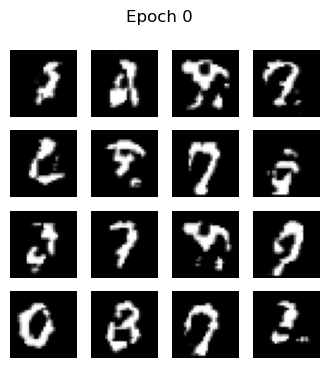

In [ ]:
def sample_images(epoch):
    z = tf.random.normal((16, LATENT_DIM))
    gen_imgs = generator(z, training=False)
    gen_imgs = (gen_imgs + 1) / 2
    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(gen_imgs[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

for epoch in range(EPOCHS):
    for real_imgs in train_dataset:
        d_loss, g_loss = train_step(real_imgs)
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
        sample_images(epoch)